In [16]:
# XGBoost – RandomizedSearchCV ile Hiperparametre Optimizasyonu (CV=3)
#Bu bölümde XGBoost algoritmasının hiperparametreleri, rastgele örnekleme (RandomizedSearchCV) ve 3 katlı çapraz doğrulama ile optimize edilecektir.

In [ ]:
from xgboost import XGBClassifier
from sklearn.model_selection import GridSearchCV
import time
import pandas as pd
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.model_selection import train_test_split

# Veri yükleniyor
df = pd.read_csv("hmeq.csv")

# Eksik kategorik veriler
df['REASON'] = df['REASON'].fillna("Unknown")
df['JOB'] = df['JOB'].fillna("Unknown")

# Sayısal veriler dolduruluyor
num_cols = df.select_dtypes(include=['float64', 'int64']).columns.drop('BAD')
imputer = IterativeImputer(random_state=42)
df[num_cols] = imputer.fit_transform(df[num_cols])

# Label encoding
le = LabelEncoder()
df['REASON'] = le.fit_transform(df['REASON'])
df['JOB'] = le.fit_transform(df['JOB'])

# X, y ayrımı
X = df.drop('BAD', axis=1)
y = df['BAD']

# Ölçekleme
scaler = StandardScaler()
X[num_cols] = scaler.fit_transform(X[num_cols])

# Eğitim/test ayrımı
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)


c:\Users\ahmet\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\impute\_iterative.py:895: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  warnings.warn(


In [ ]:
# Parametre aralıkları tanımlanıyor
param_dist = {
    'n_estimators': [100, 200, 300],
    'max_depth': [3, 5, 7, 10],
    'learning_rate': [0.01, 0.05, 0.1],
    'subsample': [0.6, 0.8, 1.0],
    'colsample_bytree': [0.6, 0.8, 1.0],
    'gamma': [0, 1, 5],
    'min_child_weight': [1, 3, 5],
    'reg_alpha': [0, 0.1, 0.5],
    'reg_lambda': [1, 1.5, 2]
}


In [19]:
# Model nesnesi
xgb = XGBClassifier(eval_metric='logloss', use_label_encoder=False, random_state=42)

# Random Search kurulumu
random_search = RandomizedSearchCV(
    estimator=xgb,
    param_distributions=param_dist,
    n_iter=50,            # 50 rastgele kombinasyon dene
    scoring='f1',
    cv=3,                 # 3 katlı çapraz doğrulama
    verbose=2,
    n_jobs=-1,
    random_state=42
)

# Eğitim süresi ölçülüyor
start = time.time()
random_search.fit(X_train, y_train)
end = time.time()

print(f"RandomizedSearchCV süresi: {end - start:.2f} saniye")


Fitting 3 folds for each of 50 candidates, totalling 150 fits


c:\Users\ahmet\AppData\Local\Programs\Python\Python313\Lib\site-packages\xgboost\training.py:183: UserWarning: [16:47:54] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


RandomizedSearchCV süresi: 11.77 saniye


In [20]:
print("En iyi parametreler:")
print(random_search.best_params_)

# En iyi model
best_xgb = random_search.best_estimator_


En iyi parametreler:
{'subsample': 1.0, 'reg_lambda': 1, 'reg_alpha': 0.5, 'n_estimators': 300, 'min_child_weight': 1, 'max_depth': 10, 'learning_rate': 0.1, 'gamma': 0, 'colsample_bytree': 0.6}


In [21]:
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score,
    f1_score, roc_auc_score, confusion_matrix,
    classification_report, RocCurveDisplay
)

y_pred_best_xgb = best_xgb.predict(X_test)
y_prob_best_xgb = best_xgb.predict_proba(X_test)[:, 1]

print("Accuracy:", accuracy_score(y_test, y_pred_best_xgb))
print("Precision:", precision_score(y_test, y_pred_best_xgb))
print("Recall:", recall_score(y_test, y_pred_best_xgb))
print("F1 Score:", f1_score(y_test, y_pred_best_xgb))
print("ROC AUC:", roc_auc_score(y_test, y_prob_best_xgb))



Accuracy: 0.9278523489932886
Precision: 0.9578313253012049
Recall: 0.6680672268907563
F1 Score: 0.7871287128712872
ROC AUC: 0.9578378521219808


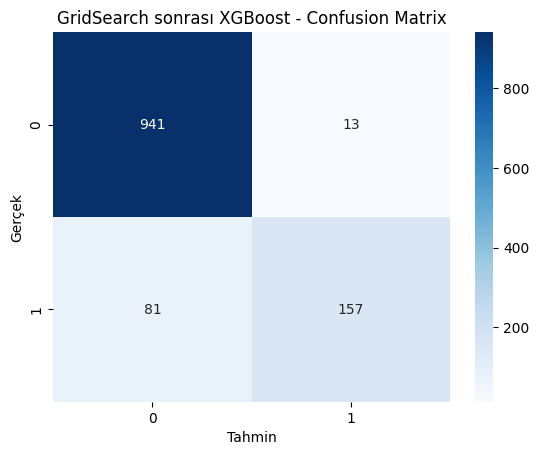

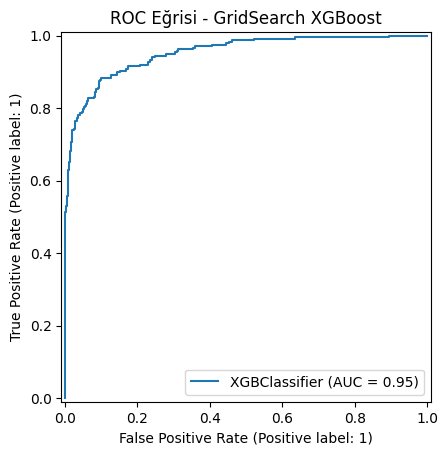

In [15]:
import matplotlib.pyplot as plt
import seaborn as sns

cm_best_xgb = confusion_matrix(y_test, y_pred_best_xgb)
sns.heatmap(cm_best_xgb, annot=True, fmt='d', cmap='Blues')
plt.title("GridSearch sonrası XGBoost - Confusion Matrix")
plt.xlabel("Tahmin")
plt.ylabel("Gerçek")
plt.show()

RocCurveDisplay.from_estimator(best_xgb, X_test, y_test)
plt.title("ROC Eğrisi - GridSearch XGBoost")
plt.show()
